In [1]:
# only permit max cut

canonical_order = ['ENZYMES', 'MUTAG', 'COLLAB', 'PROTEINS', 'IMDB-BINARY', 'BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']
def reorder(df, canonical_order, by='dataset', extras=['dataset','gen_n'], secondary='gen_n'):
    df['dataset_name_order'] = df[by].map({name: i for i, name in enumerate(canonical_order)})
    if secondary is not None:
        df = df.sort_values(by=['dataset_name_order', secondary])
    else:
        df = df.sort_values(by=['dataset_name_order'])

    columnorder = [x for x in canonical_order if x in df.keys()]
    return df[extras + columnorder]

In [2]:
import os
os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs')

['legacy',
 'Testing',
 'LiftMP_runs',
 '230924_hparam2',
 '230927_snapshot',
 '230924_hparam',
 '230924_hparam_TU_multiarch',
 '230924_hparam_TU',
 '230926_finetune_ER_runs']

In [3]:
print(list(os.path.join('230927_snapshot', x) for x in os.listdir('/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot')))

['230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC', '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']


In [4]:
run_folders = ['LiftMP_runs', '230927_snapshot/230925_TUsmall_GAT_VC', '230927_snapshot/230925_TUsmall_GIN_VC', 
               '230927_snapshot/230925_generated_preset_cut', '230927_snapshot/230925_TUlarge_all_cut', '230927_snapshot/230925_TUsmall_GCNN_VC',
                 '230927_snapshot/230925_generated_liftMP_VC', '230927_snapshot/230925_TUlarge_all_VC', '230927_snapshot/230925_generated_preset_VC', 
                 '230927_snapshot/230925_TUsmall_liftMP_VC', '230927_snapshot/230925_TUsmall_GatedGCNN_VC', '230927_snapshot/230925_generated_liftMP_cut']


In [5]:
import json
import pandas as pd
import numpy as np

folder_path = '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs'
model_list = [os.path.join(folder_path, run_folder, x) for run_folder in run_folders for x in os.listdir(os.path.join(folder_path, run_folder))  ]


rows = []

errored = []
for model_folder in model_list:
    try:
        with open(os.path.join(model_folder, 'params.txt'), 'r') as f:
            model_args = json.load(f)
        if model_args['problem_type'] != 'max_cut':
            continue
        
        losses = np.load(os.path.join(model_folder, 'valid_scores.npy'))
        test_losses = np.load(os.path.join(model_folder, 'test_scores.npy'))
        modeldict = model_args #{x: model_args[x] for x in params}
        modeldict['max_valid_score'] = max(losses)
        modeldict['max_valid_epoch'] = np.argmax(losses)
        modeldict['scores'] = test_losses[np.argmax(losses)]
        modeldict['baseline'] = False

        rows.append(modeldict)
        
    except Exception as e:
        print(f'{e} is wrong w/ {model_folder}')
        errored.append(model_folder)

[Errno 2] No such file or directory: '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot/230925_generated_preset_cut/paramhash:9a044e099b9815ba818bbc4f9c7be03b5329c1ed02ed7308e7d3a1f1288dd9cd/valid_scores.npy' is wrong w/ /home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot/230925_generated_preset_cut/paramhash:9a044e099b9815ba818bbc4f9c7be03b5329c1ed02ed7308e7d3a1f1288dd9cd
[Errno 2] No such file or directory: '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot/230925_generated_preset_cut/paramhash:4f75fa3e5744dc889c5a6088168c20d22720447af16730fb221abebc3f009d9c/valid_scores.npy' is wrong w/ /home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot/230925_generated_preset_cut/paramhash:4f75fa3e5744dc889c5a6088168c20d22720447af16730fb221abebc3f009d9c
[Errno 2] No such file or directory: '/home/bcjexu/maxcut-80/bespoke-gnn4do/training_runs/230927_snapshot/230925_generated_preset_cut/paramhash:f5e579498822836d26be0b6c6b1a8bf6cf64

In [6]:
len(errored)

39

In [7]:
# load in baselines
baselines = pd.read_csv('mc_baseline_scores.csv')

# unwind them 
for i, baseline in baselines.iterrows():
    #print(baseline.index)
    for col in baselines.keys():
        if col == 'Unnamed: 0':
            continue
        ds = col
        gen_n = np.nan
        if len(col.split('@@')) > 1:
            ds, gen_n = col.split('@@')
            gen_n = int(gen_n)

        row = {'dataset': ds, 'gen_n': gen_n, 'model_type': baseline['Unnamed: 0'], 'scores': baseline[col], 'baseline': True}
        #print(row)
        rows.append(row)


In [8]:
len(errored)

39

In [9]:
df = pd.DataFrame.from_records(rows)

In [10]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,RB_k,positional_encoding,pe_dimension,split_seed,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline
0,max_cut,0.0,230925_generated_preset_cut,GatedGCNN,8.0,NaN,4.0,4.0,0.0,32.0,...,"[5, 21]",random_walk,2.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,16071.4580,15.0,16066.7770,False
1,max_cut,0.0,230925_generated_preset_cut,GCNN,16.0,NaN,4.0,8.0,0.0,32.0,...,"[5, 21]",random_walk,4.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,499.4690,18.0,499.3810,False
2,max_cut,0.0,230925_generated_preset_cut,GCNN,16.0,NaN,4.0,16.0,0.0,32.0,...,"[5, 21]",random_walk,8.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,15695.8250,15.0,15692.1180,False
3,max_cut,0.0,230925_generated_preset_cut,GIN,16.0,NaN,4.0,4.0,0.0,32.0,...,"[5, 21]",random_walk,2.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,15722.6220,10.0,15725.4580,False
4,max_cut,0.0,230925_generated_preset_cut,GatedGCNN,16.0,NaN,4.0,8.0,0.0,32.0,...,"[5, 21]",random_walk,4.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,1902.9895,5.0,1903.0455,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
273,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
274,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
275,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [11]:
df['gen_n_max'] = df.gen_n.apply(lambda x: x[-1] if isinstance(x,list) else x)
df.gen_n = df.gen_n.apply(lambda x: x[0] if isinstance(x,list) else x)


In [12]:
df.keys()
# 'problem_type', 'seed',  'prefix', 'RB_n', 'RB_k', 'log_dir',
relevant_keys = [ 'model_type', 'num_layers',
       'repeat_lift_layers', 'num_layers_project', 'rank', 'vc_penalty', 'gen_n',
       'dataset', 'infinite',  'positional_encoding', 'pe_dimension',
       'max_valid_score', 'max_valid_epoch',
       'scores']

In [13]:
df

,problem_type,seed,prefix,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,dropout,hidden_channels,...,positional_encoding,pe_dimension,split_seed,log_dir,device,max_valid_score,max_valid_epoch,scores,baseline,gen_n_max
0,max_cut,0.0,230925_generated_preset_cut,GatedGCNN,8.0,NaN,4.0,4.0,0.0,32.0,...,random_walk,2.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,16071.4580,15.0,16066.7770,False,500.0
1,max_cut,0.0,230925_generated_preset_cut,GCNN,16.0,NaN,4.0,8.0,0.0,32.0,...,random_walk,4.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,499.4690,18.0,499.3810,False,100.0
2,max_cut,0.0,230925_generated_preset_cut,GCNN,16.0,NaN,4.0,16.0,0.0,32.0,...,random_walk,8.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,15695.8250,15.0,15692.1180,False,500.0
3,max_cut,0.0,230925_generated_preset_cut,GIN,16.0,NaN,4.0,4.0,0.0,32.0,...,random_walk,2.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,15722.6220,10.0,15725.4580,False,500.0
4,max_cut,0.0,230925_generated_preset_cut,GatedGCNN,16.0,NaN,4.0,8.0,0.0,32.0,...,random_walk,4.0,0.0,training_runs/230925_generated_preset_cut/para...,cuda,1902.9895,5.0,1903.0455,False,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,400.0
273,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,400.0
274,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
275,NaN,NaN,NaN,edge count,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,50.0


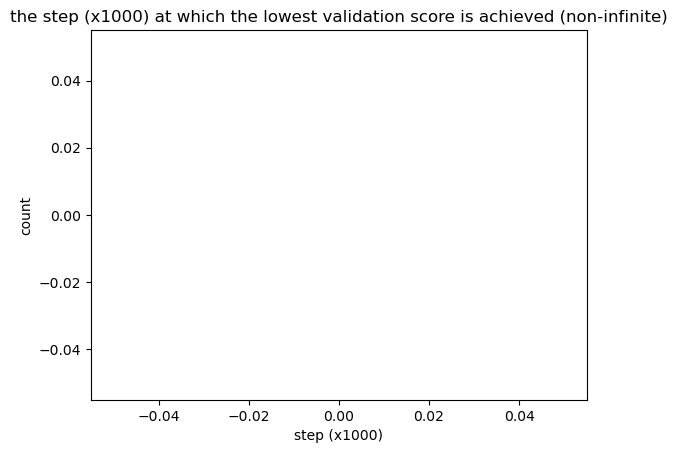

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df[df.infinite==False].max_valid_epoch)
plt.title('the step (x1000) at which the lowest validation score is achieved (non-infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 90) & (df.infinite==False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

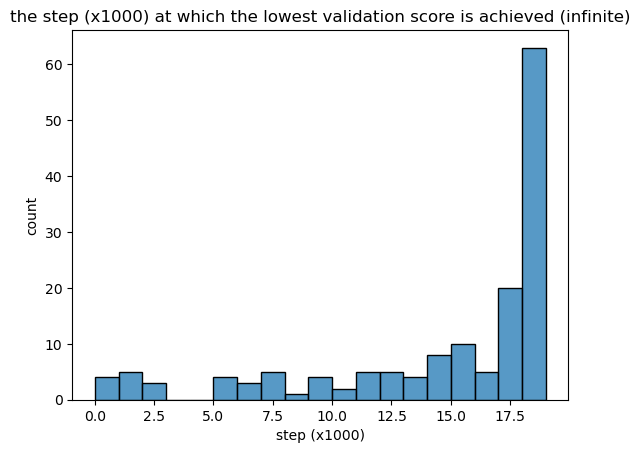

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
5,GIN,8.0,NaN,4.0,8.0,NaN,400.0,ErdosRenyi,True,random_walk,4.0,15818.7100,19.0,15818.4200
7,GCNN,8.0,NaN,4.0,8.0,NaN,50.0,ErdosRenyi,True,random_walk,4.0,486.8070,19.0,486.9650
22,GAT,8.0,NaN,4.0,8.0,NaN,400.0,ErdosRenyi,True,random_walk,4.0,16126.8980,19.0,16125.7330
33,GAT,8.0,NaN,4.0,16.0,NaN,100.0,ErdosRenyi,True,random_walk,8.0,1977.4605,19.0,1977.8215
45,GAT,8.0,NaN,4.0,4.0,NaN,50.0,ErdosRenyi,True,random_walk,2.0,524.3820,19.0,524.2270
46,GAT,8.0,NaN,4.0,16.0,NaN,400.0,ErdosRenyi,True,random_walk,8.0,16219.8760,19.0,16220.4480
48,GAT,16.0,NaN,4.0,4.0,NaN,50.0,ErdosRenyi,True,random_walk,2.0,525.6640,19.0,525.5190
49,GAT,8.0,NaN,4.0,16.0,NaN,50.0,ErdosRenyi,True,random_walk,8.0,524.5980,19.0,524.4560
50,GAT,8.0,NaN,4.0,4.0,NaN,100.0,ErdosRenyi,True,random_walk,2.0,1979.3225,19.0,1979.4475
59,GAT,16.0,NaN,4.0,4.0,NaN,100.0,ErdosRenyi,True,random_walk,2.0,1911.7305,19.0,1910.2635


In [15]:
sns.histplot(df[df.infinite!=False].max_valid_epoch, bins=range(20))
plt.title('the step (x1000) at which the lowest validation score is achieved (infinite)')
plt.xlabel("step (x1000)")
plt.ylabel('count')
plt.show()
df[(df.max_valid_epoch > 18) & (df.infinite!=False)][relevant_keys] #.to_csv('230925_checkup_late_bloomers.csv')

In [16]:
df.loc[df[df.baseline == False].groupby(['dataset', 'gen_n'])['scores'].idxmax()][relevant_keys]

,model_type,num_layers,repeat_lift_layers,num_layers_project,rank,vc_penalty,gen_n,dataset,infinite,positional_encoding,pe_dimension,max_valid_score,max_valid_epoch,scores
99,LiftMP,16.0,NaN,4.0,16.0,NaN,50.0,BarabasiAlbert,True,random_walk,8.0,351.4750,14.0,351.4880
111,LiftMP,16.0,NaN,4.0,16.0,NaN,100.0,BarabasiAlbert,True,random_walk,8.0,717.1370,18.0,717.0490
89,LiftMP,16.0,NaN,4.0,8.0,NaN,400.0,BarabasiAlbert,True,random_walk,4.0,2197.6610,7.0,2198.1090
141,LiftMP,16.0,NaN,4.0,16.0,NaN,50.0,ErdosRenyi,True,random_walk,8.0,528.8940,17.0,528.9980
127,LiftMP,16.0,NaN,4.0,16.0,NaN,100.0,ErdosRenyi,True,random_walk,8.0,1995.0125,18.0,1995.0515
140,LiftMP,16.0,NaN,4.0,8.0,NaN,400.0,ErdosRenyi,True,random_walk,4.0,16379.8390,17.0,16379.3400
84,LiftMP,16.0,NaN,4.0,16.0,NaN,50.0,PowerlawCluster,True,random_walk,8.0,345.7620,16.0,345.7410
95,LiftMP,16.0,NaN,4.0,16.0,NaN,100.0,PowerlawCluster,True,random_walk,8.0,709.4055,17.0,709.3875
106,LiftMP,16.0,NaN,4.0,8.0,NaN,400.0,PowerlawCluster,True,random_walk,4.0,2159.8360,17.0,2159.8960
101,LiftMP,16.0,NaN,4.0,16.0,NaN,50.0,WattsStrogatz,True,random_walk,8.0,198.2950,19.0,198.2850


In [17]:
df.gen_n = df.gen_n.fillna(100)

In [18]:
from collections import Counter
Counter(df.dataset)

Counter({'ErdosRenyi': 109,
         'PowerlawCluster': 38,
         'WattsStrogatz': 38,
         'BarabasiAlbert': 38,
         'ENZYMES': 6,
         'COLLAB': 6,
         'PROTEINS': 6,
         'MUTAG': 6,
         'REDDIT-BINARY': 6,
         'IMDB-BINARY': 6,
         'REDDIT-MULTI-12K': 6,
         'REDDIT-MULTI-5K': 6,
         'RANDOM': 6})

In [19]:
dataset_by_arc = pd.DataFrame()
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']
mts = ['SDP proj', 'gurobi_2.0', 'gurobi_4.0', 'gurobi_8.0', 'vertex count']



for (mt, ds, gen_n), group in df[(df.infinite == False) | (df.dataset == 'ErdosRenyi')].groupby(['model_type', 'dataset', 'gen_n']):
    if mt in mts:
        continue
    #print(mt, ds, gen_n)
    if ds in dss:
        dataset_by_arc.at[f'{ds}, {gen_n}', mt] = group['scores'].max()
    else: 
        dataset_by_arc.at[f'{ds}', mt] = group['scores'].max()


dataset_by_arc.rename(columns={'Nikos': 'CustomLiftProject'}, inplace=True)
dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'edge count']]].to_csv('Table1_maxcut.csv') #.style.highlight_max(color = 'green', axis = 1)

In [20]:
dataset_by_arc = pd.DataFrame()
mts = ['GAT', 'GCNN', 'GIN', 'GatedGCNN']
dss = ['BarabasiAlbert', 'ErdosRenyi', 'PowerlawCluster', 'WattsStrogatz']

for (mt, ds, gen_n, gen_nmax), group in df[~df.model_type.isin(mts)].groupby(['model_type', 'dataset', 'gen_n', 'gen_n_max']):
    #print(mt, ds, gen_n)
    if ds in dss:
        k = f'{ds}_{gen_n}'
    else:
        k = ds
    dataset_by_arc.at[k, 'Type'] = ds
    dataset_by_arc.at[k, 'Nmin'] = gen_n
    dataset_by_arc.at[k, 'Nmax'] = gen_nmax
    dataset_by_arc.at[k, mt] = group['scores'].max()

#dataset_by_arc.rename(columns={'Nikos': 'CustomLiftProject'}, inplace=True)
dataset_by_arc[[k for k in dataset_by_arc.keys() if k not in ['SDP lift', 'SDP proj', 'edge count']]].to_csv('Table2_maxcut.csv')#.style.highlight_max(color = 'green', axis = 1)